# Full Boss NUM density

In [22]:
import sys, os
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from matplotlib.backends.backend_pdf import PdfPages


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def valid_hp(cat, nside = 4096):
    
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=nside, nest= False)
    hpind_reject = hpRaDecToHEALPixel(cat['RA'][cat['VETO_FLAG'] == 0], 
                                    cat['DEC'][cat['VETO_FLAG'] == 0], nside=nside, nest= False)
    
    hppixnumber = np.arange(hp.nside2npix(nside))
    
    geomask = np.in1d( hppixnumber, hpind )
    rejectmask = np.in1d( hppixnumber, hpind_reject )
    
    print np.sum(geomask), np.sum(~rejectmask)
    
    
    totalmask = geomask * (~rejectmask)
    return hppixnumber[totalmask]


def hp_mask(cat, valid_hpind, nside = 4096):
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=nside, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    return HPmask




def callingBOSSmask(option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    CleanMask = np.zeros((valid_hpind.size, ), dtype=[('PIXEL', 'i4'),('RA', 'f8'), ('DEC', 'f8')])
    CleanMask['PIXEL'] = valid_hpind
    sys_ra, sys_dec = hpHEALPixelToRaDec(valid_hpind, nside = 4096)
    CleanMask['RA'] = sys_ra
    CleanMask['DEC'] = sys_dec
    return CleanMask


def BOSSvetoing(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')
    elif option =='all':
        valid_hpind = esutil.io.read(['/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits',
                                   '/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits'],
                                 combine=True)
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

#valid_hp4096 = valid_hp(mock_rand_ngc, nside = 4096)
#vetoed_obj = hp_mask(mock_rand_ngc, valid_hp4096, nside = 4096)
#print 'vetoed by flag', np.sum(mock_rand_ngc['VETO_FLAG'] == 0)
#print 'vetoed by 4096mask', mock_rand_ngc.size - np.sum(vetoed_obj)
#print 'vetoed by 2048mask', mock_rand_sgc.size - np.sum(vetoed_obj2048)

In [24]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = np.sum(GoldMask_spt['FRAC']) #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  np.sum(GoldMask_st82['FRAC']) # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [79]:
np.sum(GoldMask_spt['FRAC'] != 1.0 ), np.sum(GoldMask_spt['FRAC'] == 1.0 )

(1203861, 4949766)

In [95]:

#hpix_dmass = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=4096, nest= False)
#dmass_spt_hpix = appendColumn(dmass_spt, name = 'PIXEL', value = hpix_dmass, dtypes=None)

In [87]:
import pandas as pd
desData = pd.DataFrame(dmass_spt)
goldData = pd.DataFrame(GoldMask_spt)
matched = pd.merge(desData, goldData, left_on='HPIX', right_on='PIXEL', how='left')
matched_arr = matched.to_records(index=False)

In [97]:
from utils import mergeCatalogsUsingPandas
dmass_spt_hpix = mergeCatalogsUsingPandas(des=dmass_spt, gold=GoldMask_spt, how = 'right', 
                                      left_key='HPIX', right_key = 'PIXEL', suffixes = ['','_GOLD'], 
                                      left_index=False, right_index = False)

In [142]:
BOSSCleanMaskSGC = callingBOSSmask(option='SGC')
BOSSCleanMaskNGC = callingBOSSmask(option='NGC')
BOSSSGCMaparea = BOSSCleanMaskSGC.size * pixarea
BOSSNGCMaparea = BOSSCleanMaskNGC.size * pixarea
print BOSSSGCMaparea, BOSSNGCMaparea

2422.648564262496 6523.511490618644


In [27]:
import numpy as np

path = '/n/des/lee.5922/data/cmass_cat/'

cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]
#cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
#cmass_train = Cuts.SpatialCuts(cmass_sgc, ra=310, ra2=360, dec=-2, dec2=2)
cmass_train = Cuts.keepGoodRegion(cmass_sgc)

In [28]:
cmass = np.hstack([cmass_ngc, cmass_sgc])

In [29]:
print np.sum(cmass_train['WEIGHT_CP'])

12422.0


In [30]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

In [31]:
dmass_spt = io.SearchAndCallFits(path = rootdir, columns = None, keyword = 'dmass_spt_sys_v3.fits')
dmass_spt = dmass_spt[ dmass_spt['CMASS_PROB'] > 0.01 ]
dmass_st82 = io.SearchAndCallFits(path = rootdir, columns = None, keyword = 'gold_st82_prob.fits')
dmass_st82 =dmass_st82[ dmass_st82['EachProb_CMASS'] > 0.01]

train = esutil.io.read(rootdir+'train_sample_des.fits')
train = Cuts.keepGoodRegion(train)

dmass_spt = Cuts.keepGoodRegion(dmass_spt)
dmass_st82 = Cuts.keepGoodRegion(dmass_st82)

print np.sum(dmass_st82['EachProb_CMASS'])
print np.sum(dmass_spt['CMASS_PROB'])
print train.size


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits

--------------------------------
 calling catalog
--------------------------------
gold_st82_prob.fits
12637.112833275674
117292.90214602613
12639


In [148]:
/n/des/lee.5922/data/cmass_cat/patchy_mock/

'/n/des/lee.5922/data/cmass_cat/'

In [46]:
cmass_mock_fileN = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0011.dat')
cmass_mock_fileS = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-S-V6C-Portsmouth-mass_0011.dat')
cmass_mock_file = np.vstack([cmass_mock_fileN, cmass_mock_fileS])

In [47]:
#cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
cmass_mock = np.zeros( (cmass_mock_file.shape[0],), dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('VETO_FLAG', 'int')])
cmass_mock['RA'] = cmass_mock_file[:,0]
cmass_mock['DEC'] = cmass_mock_file[:,1]
cmass_mock['Z'] = cmass_mock_file[:,2]
cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
#cmass_mock = cmass_mock[(cmass_mock['Z'] > 0.43) & (cmass_mock['Z'] < 0.7)]
cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]

cmass_mock = BOSSvetoing(cmass_mock, option = 'all')

reading 1/2 /n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits
reading 2/2 /n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits


In [48]:
cmass_mock_fileN, cmass_mock_fileS, cmass_mock_file = None, None, None

In [110]:
def CalculateNumDensityArea(cat, hpix, weight = 'DES', weight_value = None):
    
    if weight_value is None : weight_value = np.ones(cat.size)
    Npix = hpix.size
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    vetoobjmask = np.in1d( hpind, hpix )
    
    #Nobj = np.sum(vetoedhpix)
    pixarea = hp.nside2pixarea( 4096, degrees = True)
    TotalArea = Npix * pixarea
    
    #print 'total area', TotalArea,
    
    if weight is 'DES' :
        try:
            #ncat = np.sum( cat['EachProb_CMASS'][vetoobjmask] )
            ncat = np.sum( (cat['EachProb_CMASS'] * weight_value )[vetoobjmask] )
            num_density = ncat * 1./TotalArea
            #print ' Nobj', ncat
            
        except ZeroDivisionError: num_density = 0.0
        
    elif weight is True :
        #vetoobj = cat[vetoobjmask]
        ncat = np.sum( (cat['WEIGHT_SYSTOT']*( cat['WEIGHT_CP'] +cat['WEIGHT_NOZ'] - 1 ))[vetoobjmask] ) 
        try : num_density = ncat * 1./TotalArea 
        except ZeroDivisionError: num_density = 0.0
        #print ' Nobj', ncat
        
    elif weight is False :
        ncat = cat[vetoobjmask].size
        num_density = ncat *1./TotalArea
        
    else : print 'something is wrong!!!'
    
    #print ' Nobj', ncat
    return num_density

In [33]:
# add jack knife error
def jkerror( catalog, random, njack = 10 ):
    import os
    #from suchyta_utils import _jkfunctions as _jk

    # jk error
    jkfile = './jkregion.txt'
    jk.GenerateJKRegions( catalog['RA'], catalog['DEC'], njack, jkfile)
    jktest = jk.SphericalJK( target = CalculateNumDensity, jkargs=[catalog, random], jkargsby=[['RA', 'DEC'],['RA', 'DEC']], \
                            nojkargs=[], regions = jkfile)
    jktest.DoJK( regions = jkfile )
    jkresults = jktest.GetResults(jk=True, full = True)

    
    full_j = jkresults['full']   
    it = jkresults['it']
    it_j = jkresults['jk']

    norm = (njack-1)*1./njack
    #cov = np.std(it_j)**2 * norm
    cov = np.sum((it_j - it_j.mean())**2) * norm
    
    
    os.remove(jkfile)
    return it_j.mean(), it_j, np.sqrt(cov)

In [71]:
BOSSCleanMask = np.hstack([BOSSCleanMaskSGC['PIXEL'], BOSSCleanMaskNGC['PIXEL']])
Narr = BOSSCleanMask.size/615362 #600000
HIND_BOSSCleanMask = np.split( BOSSCleanMask[:615362*Narr], Narr)
#HIND_CMASSCleanMask = np.array_split( BOSSCleanMask, BOSSCleanMask.size/600000)


n_density_CMASS = np.zeros(len(HIND_CMASSCleanMask))
i = 0
for vind in HIND_CMASSCleanMask:
    print '\r', i, '/',len(HIND_CMASSCleanMask),
    n_density_CMASS[i] = CalculateNumDensityArea(cmass, vind, weight = True )
    i += 1

    
avg_n_density_cmass = n_density_CMASS * 1./n_density_CMASS.mean()
mean_n_density_cmass = np.mean(avg_n_density_cmass)
std_n_density_cmass = np.std(avg_n_density_cmass)
area_cmass = hp.nside2pixarea( 4096, degrees = True) * HIND_CMASSCleanMask[0].size
print 'Area', area_cmass

71 / 72                                                                       Area 124.25234251277075


In [121]:
615362*Narr

31383462

In [125]:
BOSSCleanMaskNGC['PIXEL'][-( BOSSCleanMaskNGC['PIXEL'].size - 615362*Narr):]

array([103908805, 103908806, 103908807, ..., 107053888, 107053889,
       107053890], dtype=int32)

In [207]:
Narr = BOSSCleanMaskNGC['PIXEL'].size/615362 #600000
HIND_BOSSCleanMaskNGC = np.split( BOSSCleanMaskNGC['PIXEL'][:615362*Narr], Narr)
remain = [BOSSCleanMaskNGC['PIXEL'][-( BOSSCleanMaskNGC['PIXEL'].size - 615362*Narr):] ]
print remain[0].size
HIND_BOSSCleanMaskNGC = HIND_BOSSCleanMaskNGC + remain
#HIND_BOSSCleanMaskNGC = np.array_split( BOSSCleanMaskNGC['PIXEL'], Narr)

n_density_ngc = np.zeros(len(HIND_BOSSCleanMaskNGC))
i = 0
for vind in HIND_BOSSCleanMaskNGC:
    print '\r', i+1, '/',len(HIND_BOSSCleanMaskNGC),
    n_density_ngc[i] = CalculateNumDensityArea(cmass_ngc, vind, weight = True )
    i += 1
    
avg_n_density_ngc = n_density_ngc * 1./n_density_ngc.mean()
mean_n_density_ngc = np.mean(avg_n_density_ngc)
std_n_density_ngc = np.std(avg_n_density_ngc)
area_ngc = hp.nside2pixarea( 4096, degrees = True) * HIND_BOSSCleanMaskNGC[0].size
print 'Area', area_ngc
print 'number of hpix',  len(HIND_BOSSCleanMaskNGC[0]), len(HIND_BOSSCleanMaskNGC[-1])


453194
52 / 52                                                   Area 126.09116604112158
number of hpix 615362 453194


In [206]:
Narr = BOSSCleanMaskSGC['PIXEL'].size/615362 #600000
HIND_BOSSCleanMaskSGC = np.split( BOSSCleanMaskSGC['PIXEL'][:615362*Narr], Narr)
remain = [ BOSSCleanMaskSGC['PIXEL'][-(BOSSCleanMaskSGC['PIXEL'].size - 615362*Narr):] ]
print remain[0].size
HIND_BOSSCleanMaskSGC = HIND_BOSSCleanMaskSGC + remain
#HIND_BOSSCleanMaskSGC = np.array_split( BOSSCleanMaskSGC['PIXEL'], Narr)
n_density_sgc = np.zeros(len(HIND_BOSSCleanMaskSGC))
i = 0
for vind in HIND_BOSSCleanMaskSGC:
    print '\r', i+1, '/',len(HIND_BOSSCleanMaskSGC),
    n_density_sgc[i] = CalculateNumDensityArea(cmass_sgc, vind, weight = True )
    i += 1
    
avg_n_density_sgc = n_density_sgc * 1./n_density_sgc.mean()
mean_n_density_sgc = np.mean(avg_n_density_sgc)
std_n_density_sgc = np.std(avg_n_density_sgc)
area_sgc = hp.nside2pixarea( 4096, degrees = True) * HIND_BOSSCleanMaskSGC[0].size
print 'Area', area_sgc
print 'number of hpix',  len(HIND_BOSSCleanMaskSGC[0]), len(HIND_BOSSCleanMaskSGC[-1])

131360
20 / 20         Area 126.09116604112158
number of hpix 615362 131360


In [204]:
Narr = GoldMask_spt['PIXEL'].size/600000
#HIND_DMASSCleanMask = np.split( GoldMask_spt['PIXEL'][:600000*Narr], Narr)
#remain = [ GoldMask_spt['PIXEL'][-(GoldMask_spt['PIXEL'].size - 600000*Narr):] ]
#print remain[0].size
#HIND_DMASSCleanMask = HIND_DMASSCleanMask + remain
#HIND_DMASSCleanMask = HIND_DMASSCleanMask[:-1]
HIND_DMASSCleanMask = np.array_split( GoldMask_spt['PIXEL'], Narr)

#HIND_DMASSCleanMask = np.array_split( GoldMask_spt['PIXEL'], GoldMask_spt['PIXEL'].size/600000)
n_density_dmass = np.zeros(len(HIND_DMASSCleanMask))
i = 0
for vind in HIND_DMASSCleanMask:
    print '\r', i+1, '/',len(HIND_DMASSCleanMask),
    n_density_dmass[i] = CalculateNumDensityArea(dmass_spt, vind, weight = 'DES', weight_value=matched_arr['FRAC'] )
    i += 1
    
avg_n_density_dmass = n_density_dmass * 1./n_density_dmass.mean()
mean_n_density_dmass = np.mean(avg_n_density_dmass)
std_n_density_dmass = np.std(avg_n_density_dmass)
area_dmass = hp.nside2pixarea( 4096, degrees = True) * HIND_DMASSCleanMask[0].size
print 'Area', area_dmass
print 'number of hpix',  len(HIND_DMASSCleanMask[0]), len(HIND_DMASSCleanMask[-1])

10 / 10         Area 126.09137094679669
number of hpix 615363 615362


In [156]:
BOSSCleanMask = np.hstack([BOSSCleanMaskSGC['PIXEL'], BOSSCleanMaskNGC['PIXEL']])

Narr = BOSSCleanMask.size/615362 #600000
HIND_MockCleanMask = np.split( BOSSCleanMask[:615362*Narr], Narr)
#HIND_MockCleanMask = np.array_split( BOSSCleanMask, Narr)

#HIND_MockCleanMask = np.array_split( BOSSCleanMask, BOSSCleanMask.size/600000)
n_density_mock = np.zeros(len(HIND_MockCleanMask))
i = 0
for vind in HIND_MockCleanMask:
    print '\r', i+1, '/',len(HIND_MockCleanMask),
    n_density_mock[i] = CalculateNumDensityArea(cmass_mock, vind, weight = False )
    i += 1
avg_n_density_mock = n_density_mock * 1./n_density_mock.mean()
mean_n_density_mock = np.mean(avg_n_density_mock)
std_n_density_mock = np.std(avg_n_density_mock)
area_mock = hp.nside2pixarea( 4096, degrees = True) * HIND_MockCleanMask[0].size
print 'Area', area_mock
print 'number of hpix',  len(HIND_MockCleanMask[0]), len(HIND_MockCleanMask[-1])

69 / 70                                                                     Area 126.09116604112158
number of hpix 615362 615362


In [202]:
ntotal_CMASS = CalculateNumDensityArea(cmass, BOSSCleanMask, weight =  True)
ntotal_MOCK = CalculateNumDensityArea(cmass_mock, BOSSCleanMask, weight =  False)
ntotal_NGC = CalculateNumDensityArea(cmass_ngc, BOSSCleanMaskNGC['PIXEL'], weight =  True)
ntotal_SGC = CalculateNumDensityArea(cmass_sgc, BOSSCleanMaskSGC['PIXEL'], weight = True)
ntotal_DMASS = CalculateNumDensityArea(dmass_spt, GoldMask_spt['PIXEL'], weight = 'DES')
ntotal_st82 = CalculateNumDensityArea(train, GoldMask_st82['PIXEL'], weight = False)
ntotal_dmass_st82 = CalculateNumDensityArea(dmass_st82, GoldMask_st82['PIXEL'], weight = 'DES')

print ntotal_CMASS, ntotal_MOCK, ntotal_NGC, ntotal_SGC, ntotal_DMASS
print ntotal_st82, ntotal_dmass_st82

95.26011660556219 89.84357479290357 94.58998821223545 97.06455817358119 91.7751926831208
101.20055154260801 101.1854409869189


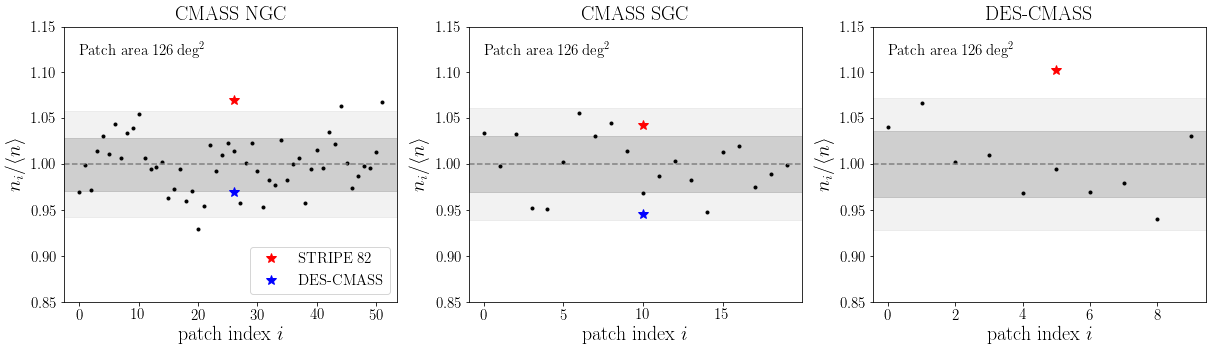

In [208]:
# plot------------------
fig,(ax, ax2, ax3) = plt.subplots(1, 3, figsize = (17, 5))


ax.axhspan( mean_n_density_ngc - std_n_density_ngc, mean_n_density_ngc + std_n_density_ngc, alpha=0.3, color='grey')#, label = r'\rm 68% confidence}')
ax.axhspan( mean_n_density_ngc - 2*std_n_density_ngc, mean_n_density_ngc + 2*std_n_density_ngc, alpha=0.1, color='grey')#, label = r'\rm 68 % confidence}')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax.plot( np.arange(avg_n_density_ngc.size), avg_n_density_ngc, marker = '.' , linestyle = 'none', color = 'black' )
ax.plot( avg_n_density_ngc.size/2., ntotal_st82/n_density_ngc.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = r'{\rm STRIPE 82}')
ax.plot( avg_n_density_ngc.size/2., ntotal_DMASS/n_density_ngc.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')

ax.axhline(y = mean_n_density_ngc, linestyle='--', color = 'grey')
ax.set_title(r'{\rm CMASS NGC}', fontsize = 20)
ax.set_ylim(0.85, 1.15)
ax.legend(loc=4, fontsize = 15)
ax.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_ngc), fontsize = 15)
#ax.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax.tick_params(labelsize = 15)


ax2.axhspan( mean_n_density_sgc - std_n_density_sgc, mean_n_density_sgc + std_n_density_sgc, alpha=0.3, color='grey')#, label = '68 % confidence')
ax2.axhspan( mean_n_density_sgc - 2*std_n_density_sgc, mean_n_density_sgc + 2*std_n_density_sgc, alpha=0.1, color='grey')#, label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax2.plot( np.arange(avg_n_density_sgc.size), avg_n_density_sgc, marker = '.' , linestyle = 'none', color = 'black' )
ax2.plot( avg_n_density_sgc.size/2., ntotal_st82/n_density_sgc.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = r'{\rm STRIPE 82}')
ax2.plot( avg_n_density_sgc.size/2., ntotal_DMASS/n_density_sgc.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')
ax2.axhline(y = mean_n_density_sgc, linestyle='--', color = 'grey')

ax2.set_title(r'{\rm CMASS SGC}', fontsize = 20)
ax2.set_ylim(0.85, 1.15)
#ax2.legend(loc=4, fontsize = 15)
ax2.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax2.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax2.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_sgc), fontsize = 15)
#ax2.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax2.tick_params(labelsize = 15)



ax3.axhspan( mean_n_density_dmass - std_n_density_dmass, mean_n_density_dmass + std_n_density_dmass, alpha=0.3, color='grey', label = '68 % confidence')
ax3.axhspan( mean_n_density_dmass - 2*std_n_density_dmass, mean_n_density_dmass + 2*std_n_density_dmass, alpha=0.1, color='grey', label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax3.plot( np.arange(avg_n_density_dmass.size), avg_n_density_dmass, marker = '.' , linestyle = 'none', color = 'black' )
ax3.plot( avg_n_density_dmass.size/2., ntotal_st82/n_density_dmass.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = 'STRIPE 82')
ax3.axhline(y = mean_n_density_dmass, linestyle='--', color = 'grey')

ax3.set_title(r'{\rm DES-CMASS}', fontsize = 20)
ax3.set_ylim(0.85, 1.15)
#ax3.legend(loc=4, fontsize = 15)
ax3.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax3.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax3.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_dmass), fontsize = 15)
#ax3.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax3.tick_params(labelsize = 15)

fig.tight_layout()
fig.savefig('../paper_figure/ndensity-sameA.pdf')

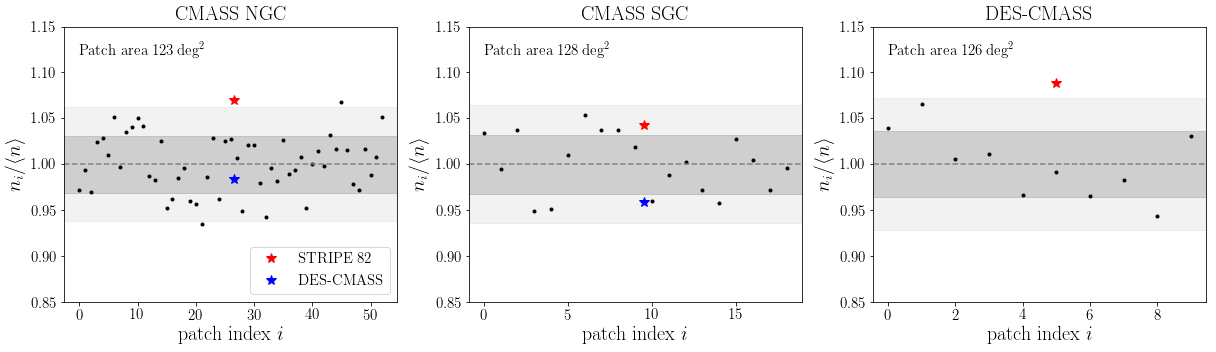

In [287]:
# plot------------------
fig,(ax, ax2, ax3) = plt.subplots(1, 3, figsize = (17, 5))


ax.axhspan( mean_n_density_ngc - std_n_density_ngc, mean_n_density_ngc + std_n_density_ngc, alpha=0.3, color='grey')#, label = r'\rm 68% confidence}')
ax.axhspan( mean_n_density_ngc - 2*std_n_density_ngc, mean_n_density_ngc + 2*std_n_density_ngc, alpha=0.1, color='grey')#, label = r'\rm 68 % confidence}')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax.plot( np.arange(avg_n_density_ngc.size), avg_n_density_ngc, marker = '.' , linestyle = 'none', color = 'black' )
ax.plot( avg_n_density_ngc.size/2., ntotal_st82/n_density_ngc.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = r'{\rm STRIPE 82}')
ax.plot( avg_n_density_ngc.size/2., ntotal_DMASS/n_density_ngc.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')

ax.axhline(y = mean_n_density_ngc, linestyle='--', color = 'grey')
ax.set_title(r'{\rm CMASS NGC}', fontsize = 20)
ax.set_ylim(0.85, 1.15)
ax.legend(loc=4, fontsize = 15)
ax.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_ngc), fontsize = 15)
#ax.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax.tick_params(labelsize = 15)


ax2.axhspan( mean_n_density_sgc - std_n_density_sgc, mean_n_density_sgc + std_n_density_sgc, alpha=0.3, color='grey')#, label = '68 % confidence')
ax2.axhspan( mean_n_density_sgc - 2*std_n_density_sgc, mean_n_density_sgc + 2*std_n_density_sgc, alpha=0.1, color='grey')#, label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax2.plot( np.arange(avg_n_density_sgc.size), avg_n_density_sgc, marker = '.' , linestyle = 'none', color = 'black' )
ax2.plot( avg_n_density_sgc.size/2., ntotal_st82/n_density_sgc.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = r'{\rm STRIPE 82}')
ax2.plot( avg_n_density_sgc.size/2., ntotal_DMASS/n_density_sgc.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')
ax2.axhline(y = mean_n_density_sgc, linestyle='--', color = 'grey')

ax2.set_title(r'{\rm CMASS SGC}', fontsize = 20)
ax2.set_ylim(0.85, 1.15)
#ax2.legend(loc=4, fontsize = 15)
ax2.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax2.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax2.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_sgc), fontsize = 15)
#ax2.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax2.tick_params(labelsize = 15)



ax3.axhspan( mean_n_density_dmass - std_n_density_dmass, mean_n_density_dmass + std_n_density_dmass, alpha=0.3, color='grey', label = '68 % confidence')
ax3.axhspan( mean_n_density_dmass - 2*std_n_density_dmass, mean_n_density_dmass + 2*std_n_density_dmass, alpha=0.1, color='grey', label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax3.plot( np.arange(avg_n_density_dmass.size), avg_n_density_dmass, marker = '.' , linestyle = 'none', color = 'black' )
ax3.plot( avg_n_density_dmass.size/2., n_density_st82/n_density_dmass.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = 'STRIPE 82')
ax3.axhline(y = mean_n_density_dmass, linestyle='--', color = 'grey')

ax3.set_title(r'{\rm DES-CMASS}', fontsize = 20)
ax3.set_ylim(0.85, 1.15)
#ax3.legend(loc=4, fontsize = 15)
ax3.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax3.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax3.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_dmass), fontsize = 15)
#ax3.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax3.tick_params(labelsize = 15)

fig.tight_layout()
fig.savefig('../paper_figure/ndensity.pdf')

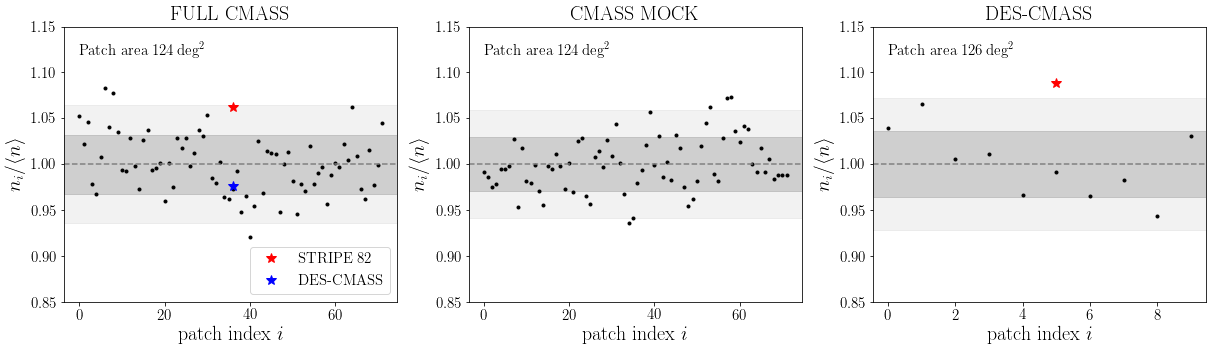

In [288]:
fig,(ax, ax2, ax3) = plt.subplots(1, 3, figsize = (17, 5))

ax.axhspan( mean_n_density_cmass - std_n_density_cmass, mean_n_density_cmass + std_n_density_cmass, alpha=0.3, color='grey')#, label = '68 % confidence')
ax.axhspan( mean_n_density_cmass - 2*std_n_density_cmass, mean_n_density_cmass + 2*std_n_density_cmass, alpha=0.1, color='grey')#, label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax.plot( np.arange(avg_n_density_cmass.size), avg_n_density_cmass, marker = '.' , linestyle = 'none', color = 'black' )
ax.plot( avg_n_density_cmass.size/2., n_density_st82/n_density_CMASS.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = r'{\rm STRIPE 82}')
ax.plot( avg_n_density_cmass.size/2., ntotal_DMASS/n_density_CMASS.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')

ax.axhline(y = mean_n_density_ngc, linestyle='--', color = 'grey')

ax.set_title(r'{\rm FULL CMASS}', fontsize = 20)
ax.set_ylim(0.85, 1.15)
ax.legend(loc=4, fontsize = 15)
ax.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_cmass), fontsize = 15)
#ax.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax.tick_params(labelsize = 15)


ax2.axhspan( mean_n_density_mock - std_n_density_mock, mean_n_density_mock + std_n_density_mock, alpha=0.3, color='grey', label = '68 % confidence')
ax2.axhspan( mean_n_density_mock - 2*std_n_density_mock, mean_n_density_mock + 2*std_n_density_mock, alpha=0.1, color='grey', label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax2.plot( np.arange(avg_n_density_mock.size), avg_n_density_mock, marker = '.' , linestyle = 'none', color = 'black' )
#ax2.plot( avg_n_density_mock.size/2., n_density_st82/n_density_mock.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = 'st82')
#ax2.plot( avg_n_density_mock.size/2., ntotal_DMASS/n_density_mock.mean(), marker = '*', color = 'blue',  markersize = 10, linestyle = 'none', label = r'{\rm DES-CMASS}')

ax2.axhline(y = mean_n_density_ngc, linestyle='--', color = 'grey')

ax2.set_title(r'{\rm CMASS MOCK}', fontsize = 20)
ax2.set_ylim(0.85, 1.15)
#ax2.legend(loc=4, fontsize = 15)
ax2.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax2.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax2.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_mock), fontsize = 15)
#ax2.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax2.tick_params(labelsize = 15)


ax3.axhspan( mean_n_density_dmass - std_n_density_dmass, mean_n_density_dmass + std_n_density_dmass, alpha=0.3, color='grey', label = '68 % confidence')
ax3.axhspan( mean_n_density_dmass - 2*std_n_density_dmass, mean_n_density_dmass + 2*std_n_density_dmass, alpha=0.1, color='grey', label = '68 % confidence')
#ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density_ngc_norm.size), n_density_ngc_norm, yerr = err_ngc, fmt='o' )
ax3.plot( np.arange(avg_n_density_dmass.size), avg_n_density_dmass, marker = '.' , linestyle = 'none', color = 'black' )
ax3.plot( avg_n_density_dmass.size/2., n_density_st82/n_density_dmass.mean(), marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = 'st82')
ax3.axhline(y = mean_n_density_dmass, linestyle='--', color = 'grey')

ax3.set_title(r'{\rm DES-CMASS}', fontsize = 20)
ax3.set_ylim(0.85, 1.15)
#ax3.legend(loc=4, fontsize = 15)
ax3.set_ylabel(r'$n_i / \langle n \rangle$', fontsize = 20)
ax3.set_xlabel(r'{\rm patch index $i$}', fontsize = 20)
ax3.text(0, 1.12, r'{\rm  Patch area }'+ r'${:0.0f} \deg^2$'.format(area_dmass), fontsize = 15)
#ax3.text(0, 1.10, r'{\rm  St82 area }'+ r'${:0.0f} \deg^2$'.format(123), fontsize = 15)
ax3.tick_params(labelsize = 15)

fig.tight_layout()
fig.savefig('../paper_figure/ndensity_mock.pdf')